### And welcome to Week 4, Day 3 - more LangGraph..

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict

In [ ]:
load_dotenv(override=True)

True

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris is the capit

### LangChain wrapper class for converting functions into Tools

In [4]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )

In [5]:
tool_search.invoke("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris is the capital city of France and a cultural and culinary hub. In 2024 it played host to its third Olympic Games. Paris, situated on the river Seine ... Paris, the capital ci

In [6]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [7]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

In [8]:
tools = [tool_search, tool_push]

In [9]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
graph_builder = StateGraph(State)

In [11]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [12]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [13]:
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

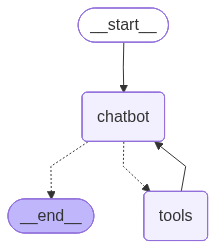

In [14]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

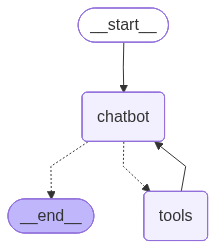

In [17]:
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='70183323-1949-4d8d-92d1-f13169994b06')]}
{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='70183323-1949-4d8d-92d1-f13169994b06'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CfOxjLwcKTL1qmC2HFaDN0d2TL7je', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0c06b84e-aeb4-40b7-b054-dc1a84c55f0b-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_det

In [19]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='70183323-1949-4d8d-92d1-f13169994b06'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CfOxjLwcKTL1qmC2HFaDN0d2TL7je', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0c06b84e-aeb4-40b7-b054-dc1a84c55f0b-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(co

In [20]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='70183323-1949-4d8d-92d1-f13169994b06'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CfOxjLwcKTL1qmC2HFaDN0d2TL7je', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0c06b84e-aeb4-40b7-b054-dc1a84c55f0b-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(c

In [21]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

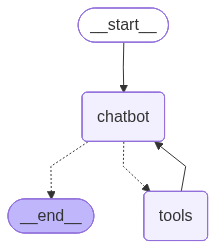

In [22]:
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='d6144090-9963-438c-b21b-3fb4f06edbc0'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 90, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BInN7JUnEYNTQqokCF3eihp5oKP0V', 'finish_reason': 'stop', 'logprobs': None}, id='run-4b488710-73ac-435e-a944-913a0c812d08-0', usage_metadata={'input_tokens': 90, 'output_tokens': 11, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content="what's my name", additional_kwargs